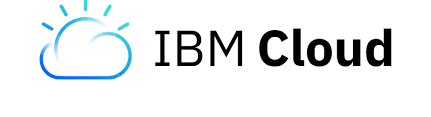

# Spark  Supervised Machine Learning

Keep the main [Spark ML documentation](https://spark.apache.org/docs/latest/ml-pipeline.html) as you go through this tutorial.  MLlib is Spark’s machine learning (ML) library. **Spark ML** is not an official name, but we will use it to refer to the MLlib DataFrame-based API that embraces ML pipelines. Before we get into Spark ML by demonstrating a couple of examples we will first review Spark DataFrames.

In [1]:
import re
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

DATA_DIR = os.path.join("..","data")

## Spark SQL and DataFrames

What is Spark SQL?
- Spark SQL takes basic RDDs and **puts a schema on them**.

What is a DataFrame?
- DataFrames are the primary abstraction in Spark SQL.
- Think of a DataFrames as **RDDs with schema**.

What are **schemas**?
- Schemas are metadata about your data.
- Schema = Table Names + Column Names + Column Types

What are the pros of schemas?
- Schemas enable using **column names** instead of column positions
- Schemas enable **queries** using SQL and DataFrame syntax
- Schemas make your data more **structured**.

See the [Spark SQL documentation](https://spark.apache.org/docs/latest/sql-programming-guide.html) as a main point of reference for Spark SQL, DataFrames and Datasets.

## Creating DataFrames

You can create a DataFrame from an existing RDD (whatever source you used to create this one), if you add a schema.

To build a schema, you will use existing data types provided in the [`pyspqrk.sql.types`](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.types) module.  

<center>
<table style="width:50%">
  <tr>
      <th>Types</th>
      <th>Python Equivalent</th>
    </tr>
  <tr>
      <td>StringType</td>
      <td>string</td>
  </tr>
  <tr>
      <td>IntegerType</td>
      <td>integer</td>
   <tr>
      <td>FloatType</td>
      <td>float</td> 
  <tr>
      <td>ArrayType</td>
      <td>array or list</td>
   </tr>
    <tr>
      <td>MapType</td>
      <td>dict</td>
   </tr>       
</table>
</center>

First we initialize the Spark Environment

In [3]:
import pyspark as ps

spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("spark-ml-examples") \
            .getOrCreate()

sc = spark.sparkContext

the `local[4]` will create a `local` cluster made of the driver using all 4 cores.  Lets start with a very small file to to demonstrate the different ways to create Spark DataFrames.

In [4]:
def casting_function(args):
    user_id, date, num_streams, country, invoice_item = args
    return((int(user_id), date, int(num_streams), country, int(invoice_item)))

rdd_aavail = sc.textFile(os.path.join(DATA_DIR, 'example-data.csv'))\
                         .map(lambda rowstr : rowstr.split(","))\
                         .filter(lambda row: not row[0].startswith('#'))\
                         .map(casting_function)

rdd_aavail.collect()

[(111, '10/13/2019', 4, 'US', 1),
 (122, '10/15/2019', 5, 'SG', 1),
 (102, '10/16/2019', 11, 'US', 1),
 (144, '10/25/2019', 14, 'US', 2),
 (121, '10/26/2019', 7, 'SG', 1),
 (155, '10/27/2019', 9, 'US', 3)]

You can create a Spark DataFrame using a schema that you have defined or it can be inferred.  To create your own. 

In [5]:
from pyspark.sql.types import *

schema = StructType([
    StructField('user_id', IntegerType(), True),
    StructField('date', StringType(), True),
    StructField('num_streams', IntegerType(), True),
    StructField('country', StringType(), True),
    StructField('invoice_items', IntegerType(), True) ])
    
# feed that into a DataFrame
df = spark.createDataFrame(rdd_aavail, schema)

# show the result
df.show()

# print the schema
df.printSchema()  

+-------+----------+-----------+-------+-------------+
|user_id|      date|num_streams|country|invoice_items|
+-------+----------+-----------+-------+-------------+
|    111|10/13/2019|          4|     US|            1|
|    122|10/15/2019|          5|     SG|            1|
|    102|10/16/2019|         11|     US|            1|
|    144|10/25/2019|         14|     US|            2|
|    121|10/26/2019|          7|     SG|            1|
|    155|10/27/2019|          9|     US|            3|
+-------+----------+-----------+-------+-------------+

root
 |-- user_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_streams: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- invoice_items: integer (nullable = true)



You may also read the data directly from a file and **infer** the schema

In [6]:
# read CSV
df = spark.read.csv(os.path.join(DATA_DIR, 'example-data.csv'),
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?


# some functions are still valid
print("line count: {}".format(df.count()))

# show the table in a nice format
df.show()

# prints the schema
df.printSchema()

line count: 6
+-----+----------+-----------+-------+------------+
|#user|      date|num_streams|country|invoice_item|
+-----+----------+-----------+-------+------------+
|  111|10/13/2019|          4|     US|           1|
|  122|10/15/2019|          5|     SG|           1|
|  102|10/16/2019|         11|     US|           1|
|  144|10/25/2019|         14|     US|           2|
|  121|10/26/2019|          7|     SG|           1|
|  155|10/27/2019|          9|     US|           3|
+-----+----------+-----------+-------+------------+

root
 |-- #user: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_streams: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- invoice_item: integer (nullable = true)



You can turn the DataFrame into a Panda DataFrame, but be careful since this 'action' will put all the data into memory

In [7]:
df.toPandas()

,#user,date,num_streams,country,invoice_item
0,111,10/13/2019,4,US,1
1,122,10/15/2019,5,SG,1
2,102,10/16/2019,11,US,1
3,144,10/25/2019,14,US,2
4,121,10/26/2019,7,SG,1
5,155,10/27/2019,9,US,3


Here are some common operations that you might perform on a DataFrame

In [8]:
# prints the schema
print("--- printSchema()")
df.printSchema()

# prints the table itself
print("--- show()")
df.show()

# show the statistics of all numerical columns
print("--- describe()")
df.describe().show()

# show the statistics of one specific column
print("--- describe(Amount)")
df.describe("num_streams").show()

--- printSchema()
root
 |-- #user: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_streams: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- invoice_item: integer (nullable = true)

--- show()
+-----+----------+-----------+-------+------------+
|#user|      date|num_streams|country|invoice_item|
+-----+----------+-----------+-------+------------+
|  111|10/13/2019|          4|     US|           1|
|  122|10/15/2019|          5|     SG|           1|
|  102|10/16/2019|         11|     US|           1|
|  144|10/25/2019|         14|     US|           2|
|  121|10/26/2019|          7|     SG|           1|
|  155|10/27/2019|          9|     US|           3|
+-----+----------+-----------+-------+------------+

--- describe()
+-------+------------------+----------+-----------------+-------+------------------+
|summary|             #user|      date|      num_streams|country|      invoice_item|
+-------+------------------+----------+-----------------+

## Transformations on DataFrames

- They are still **lazy**: Spark doesn't apply the transformation right away, it just builds on the **DAG**
- They transform a DataFrame into another because DataFrames are also **immutable**.
- They can be **wide** or **narrow** (whether they shuffle partitions or not).


Lets read in in the AAVAIL dataset that we have been working with to demonstrate the transformations.

In [9]:
# read CSV
df_aavail = spark.read.csv(os.path.join(DATA_DIR, 'aavail-target.csv'),
                           header=True,       
                           quote='"',         
                           sep=",",          
                           inferSchema=True)
df_aavail.describe().show()

+-------+-----------------+------------------+-------------+------------------+--------------+----------------+-----------------+
|summary|      customer_id|     is_subscriber|      country|               age| customer_name| subscriber_type|      num_streams|
+-------+-----------------+------------------+-------------+------------------+--------------+----------------+-----------------+
|  count|             1000|              1000|         1000|              1000|          1000|            1000|             1000|
|   mean|            500.5|             0.711|         null|            25.325|          null|            null|           17.695|
| stddev|288.8194360957494|0.4535247343692345|         null|12.184655959067568|          null|            null|4.798020007877829|
|    min|                1|                 0|    singapore|               -50|Aaliyah Duarte|    aavail_basic|                1|
|    max|             1000|                 1|united_states|                50|   Zoie Cor

## Remove one or more columns

In [17]:
columns_to_drop = ['customer_id', 'customer_name']
df_aavail = df_aavail.drop(*columns_to_drop)
df_aavail.describe().show()
df_aavail.groupBy("subscriber_type").count().show()

+-------+------------------+-------------+------------------+----------------+-----------------+
|summary|     is_subscriber|      country|               age| subscriber_type|      num_streams|
+-------+------------------+-------------+------------------+----------------+-----------------+
|  count|              1000|         1000|              1000|            1000|             1000|
|   mean|             0.711|         null|            25.325|            null|           17.695|
| stddev|0.4535247343692345|         null|12.184655959067568|            null|4.798020007877829|
|    min|                 0|    singapore|               -50|    aavail_basic|                1|
|    max|                 1|united_states|                50|aavail_unlimited|               29|
+-------+------------------+-------------+------------------+----------------+-----------------+

+----------------+-----+
| subscriber_type|count|
+----------------+-----+
|  aavail_premium|  331|
|aavail_unlimited|  302|
|

In [60]:
df_aavail.show()

+-------------+-------------+---+----------------+-----------+
|is_subscriber|      country|age| subscriber_type|num_streams|
+-------------+-------------+---+----------------+-----------+
|            1|united_states| 21|  aavail_premium|         23|
|            0|    singapore| 30|aavail_unlimited|         12|
|            0|united_states| 21|  aavail_premium|         22|
|            1|united_states| 20|    aavail_basic|         19|
|            1|    singapore| 21|  aavail_premium|         23|
|            1|united_states| 21|  aavail_premium|         20|
|            0|    singapore| 48|    aavail_basic|         18|
|            1|united_states| 47|  aavail_premium|         20|
|            0|united_states| 21|  aavail_premium|         24|
|            0|united_states| 26|    aavail_basic|         20|
|            1|united_states| 14|  aavail_premium|         18|
|            0|    singapore| 39|aavail_unlimited|          1|
|            1|united_states| 20|  aavail_premium|     

## Transformations on a feature matrix

The following example demonstrates how to deal with categorical features and scale continuous ones

In [95]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes

from pyspark.ml import Pipeline

## scale the continuous features
va = VectorAssembler(inputCols=["age", "num_streams"], outputCol="cont_features")
ss = MinMaxScaler(inputCol="cont_features", outputCol="cont_scaled")



## categorical variable transformation
cat_cols = ["country", "subscriber_type"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in cat_cols]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_oh") for column in cat_cols]



## assemple the features for input into the ML model
assembler = VectorAssembler(inputCols=["cont_scaled", "country_oh", "subscriber_type_oh"], outputCol="features")

## setup a model
gbt = NaiveBayes(labelCol="is_subscriber", featuresCol="features")
paramMap = {gbt.smoothing: 1.0}

In [96]:
df_aavail

DataFrame[is_subscriber: int, country: string, age: int, subscriber_type: string, num_streams: int]

## Setup the pipeline and train the model

In [97]:
## run the whole pipeline
pipe = Pipeline(stages=indexers+encoders+[va, ss, assembler])
model = pipe.fit(df_aavail, paramMap)
result = model.transform(df_aavail)
#result.select("features", "is_subscriber", "rawPrediction", "probability", "prediction").show()

In [98]:
result.select('features').show()

+--------------------+
|            features|
+--------------------+
|[0.71,0.785714285...|
|(5,[0,1],[0.8,0.3...|
|[0.71,0.75,1.0,0....|
|[0.70000000000000...|
|[0.71,0.785714285...|
|[0.71,0.678571428...|
|[0.98,0.607142857...|
|[0.97,0.678571428...|
|[0.71,0.821428571...|
|[0.76,0.678571428...|
|[0.64,0.607142857...|
|      (5,[0],[0.89])|
|[0.70000000000000...|
|[0.69000000000000...|
|[0.72,0.678571428...|
|[0.72,0.142857142...|
|[0.77,0.821428571...|
|[0.94000000000000...|
|[0.78,0.642857142...|
|[0.70000000000000...|
+--------------------+
only showing top 20 rows



In [100]:
nb = gbt.fit(result)
nb_pred = nb.transform(result)
nb_pred.select("features", "is_subscriber", "rawPrediction", "probability", "prediction").show()

+--------------------+-------------+--------------------+--------------------+----------+
|            features|is_subscriber|       rawPrediction|         probability|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|[0.71,0.785714285...|            1|[-6.8882711018806...|[0.28730445923614...|       1.0|
|(5,[0,1],[0.8,0.3...|            0|[-2.7016890688835...|[0.34042616474719...|       1.0|
|[0.71,0.75,1.0,0....|            0|[-6.8378085066757...|[0.28617076242146...|       1.0|
|[0.70000000000000...|            1|[-6.8393896703151...|[0.21511681147930...|       1.0|
|[0.71,0.785714285...|            1|[-5.0696349158897...|[0.41398066341604...|       1.0|
|[0.71,0.678571428...|            1|[-6.7368833162658...|[0.28391142968340...|       1.0|
|[0.98,0.607142857...|            0|[-5.2876457461570...|[0.33684639194208...|       1.0|
|[0.97,0.678571428...|            1|[-7.0315699692295...|[0.29567101039979...|       1.0|
|[0.71,0.8

In [104]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="is_subscriber", metricName="areaUnderROC",
                                         rawPredictionCol='rawPrediction')
accuracy = evaluator.evaluate(nb_pred)
print("AUC = %g " % (accuracy))

AUC = 0.340266 


Now the same procedure with a train-test split, cross-validations and grid-search

In [105]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train, test = df_aavail.randomSplit([0.8, 0.2], seed=42)

gbt = NaiveBayes(labelCol="is_subscriber", featuresCol="features")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.smoothing, [1.0, 0.8]) \
    .build()

pipe = Pipeline(stages=indexers+encoders+[va, ss, assembler])
pipeline_model = pipe.fit(train)
prepped_train = pipeline_model.transform(train)
prepped_test = pipeline_model.transform(test)

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="is_subscriber"),
                          numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(prepped_train)
print("model trained")

model trained


In [106]:
prediction = cvModel.transform(prepped_test)
result = prediction.select("features", "is_subscriber", "rawPrediction", "probability", "prediction")
result.show()

+--------------------+-------------+--------------------+--------------------+----------+
|            features|is_subscriber|       rawPrediction|         probability|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|[0.04,0.607142857...|            0|[-4.2080035225333...|[0.30112761374337...|       1.0|
|[0.65,0.5,0.0,0.0...|            0|[-4.5867740794712...|[0.39625947011427...|       1.0|
|[0.67,0.25,0.0,1....|            0|[-4.4231205125499...|[0.31747813368022...|       1.0|
|(5,[0,1],[0.67,0....|            0|[-2.4414127273597...|[0.33476839555953...|       1.0|
|[0.68,0.285714285...|            0|[-4.3188923307313...|[0.38990079563100...|       1.0|
|[0.68,0.678571428...|            0|[-4.8727455277062...|[0.40434522598237...|       1.0|
|[0.69000000000000...|            0|[-4.5317001582892...|[0.39563104565363...|       1.0|
|(5,[0,1],[0.69000...|            0|[-2.5649266386710...|[0.33814884517245...|       1.0|
|[0.700000

In [107]:
predictions = prediction.select("is_subscriber", "rawPrediction")
list(predictions)

[Column<b'is_subscriber'>, Column<b'rawPrediction'>]

In [108]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

predictionLabelsRDD = prediction.select('is_subscriber','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['is_subscriber'])))
# Instantiate metrics object
print(predictionLabelsRDD)
metrics = BinaryClassificationMetrics(predictionLabelsRDD)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

PythonRDD[1398] at RDD at PythonRDD.scala:53
Area under PR = 0.7345679012345679
Area under ROC = 0.5


In [109]:
cvModel.avgMetrics

[0.3447587038374404, 0.3447587038374404]